<a href="https://colab.research.google.com/github/priyeshroy10155/Happymonk_assignment/blob/main/Time_serise(01).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

df = pd.read_csv('/content/drive/MyDrive/Time_seris/c6d6111ee1b469cf39683bd70fab1c93-b2546c195e6793e00ed23c97a982ce439f4f95aa (1)/c6d6111ee1b469cf39683bd70fab1c93-b2546c195e6793e00ed23c97a982ce439f4f95aa/synchrony_sample.csv')

Person correlation

Pandas computed Pearson r: 0.20587745135619312
Scipy computed Pearson r: 0.2058774513561935 and p-value: 3.790298947947356e-51


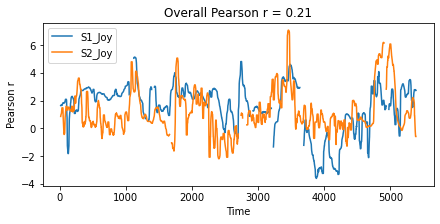

In [6]:

overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(df.dropna()['S1_Joy'], df.dropna()['S2_Joy'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Time Lagged Cross Correlation 

Text(0.5, 0.98, 'Smiling data and rolling window correlation')

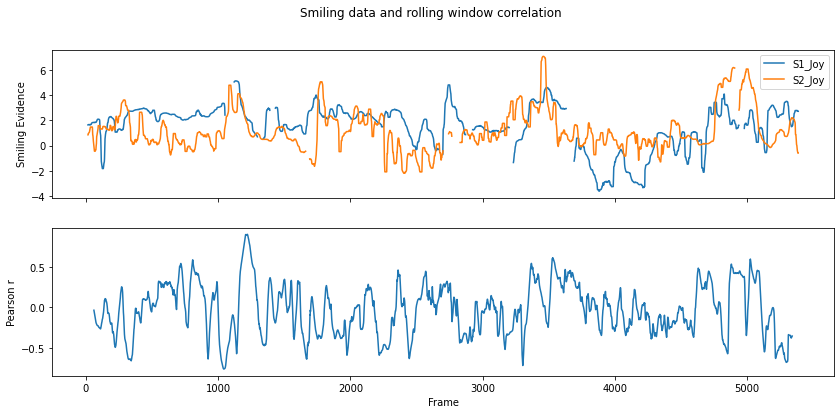

In [7]:
# Set window size to compute moving window synchrony.
r_window_size = 120
# Interpolate missing data.
df_interpolated = df.interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['S1_Joy'].rolling(window=r_window_size, center=True).corr(df_interpolated['S2_Joy'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df.rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")

Time Lagged Cross Correlation — assessing signal dynamics


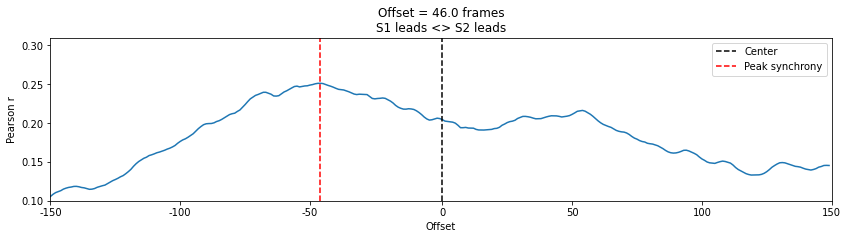

In [8]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['S1_Joy']
d2 = df['S2_Joy']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()

# solution start from here 
*we use to matching a large time series data and a small time series data we use here Dynamic time warping method*

In [17]:
! pip install dtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5314 sha256=2c471c9b3d26471faa75f76a3dea372dfddceba110d37259192fc8263c6632d3
  Stored in directory: /root/.cache/pip/wheels/5b/cc/44/62f60769f89e834ab2124c69de4005c771e0ff06af908bbbf3
Successfully built dtw


Dynamic Time Warping — synchrony of signals varying in lengths

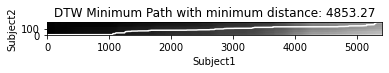

In [18]:
from dtw import dtw,accelerated_dtw

d1 = df['S1_Joy'].interpolate().values
d2 = df['S2_Joy'][100:300].interpolate().values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

In [19]:
def dtw(s, t, window):
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)])
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [20]:
d1 = df['S1_Joy']  # size 5400
d2 = df['S2_Joy'].iloc[100:300]  #size 200
d1 = df['S1_Joy'].interpolate().values
d2 = df['S2_Joy'].interpolate().values
dtw(d1,d2,window=10)

array([[0.00000000e+00,            inf,            inf, ...,
                   inf,            inf,            inf],
       [           inf, 1.05096380e+00, 2.01526910e+00, ...,
                   inf,            inf,            inf],
       [           inf, 2.02450860e+00, 1.93785010e+00, ...,
                   inf,            inf,            inf],
       ...,
       [           inf,            inf,            inf, ...,
        9.23217398e+03, 9.23618714e+03, 9.23990556e+03],
       [           inf,            inf,            inf, ...,
        9.23272722e+03, 9.23674037e+03, 9.24045879e+03],
       [           inf,            inf,            inf, ...,
        9.23020198e+03, 9.23433008e+03, 9.23816345e+03]])

Instantaneous phase synchrony

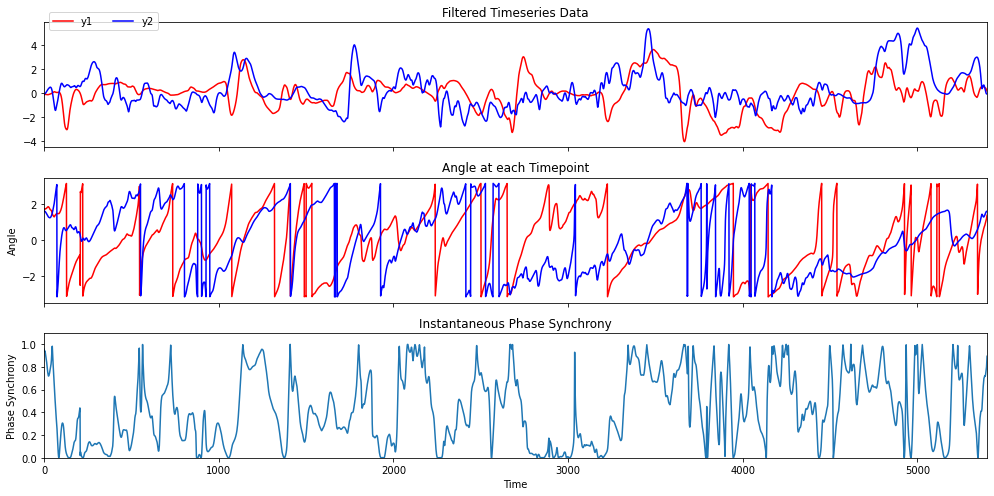

In [21]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

lowcut  = .01
highcut = .5
fs = 30.
order = 1
d1 = df['S1_Joy'].interpolate().values
d2 = df['S2_Joy'].interpolate().values
y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
N = len(al1)

# Plot results
f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()